In [ ]:
%pip install --upgrade --quiet langchain-google-vertexai langchain openai langchain_community chromadb tiktoken pypdf  langchain-google-genai  langchain_openai langchainhub langchain_chroma

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = '' # get your own OpenAI API key for embeddings

api_key= ''# get your own Google API key for generative AI
os.environ["GOOGLE_API_KEY"] = api_key


## VertexAI and Langchain

First, go to your `GCP console`   (https://console.cloud.google.com/welcome) and select the project you want to work on.
You will need to follow the following steps to get your GCP project crednetials and you start working using both Vertex AI and Langchain.

- Make sure you enable [Vertex AI](https://cloud.google.com/vertex-ai?hl=en)
- Navigate to the IAM & Admin Section:
From the left-hand menu, select "IAM & Admin" and then "Service Accounts".

* Create a Service Account:

* Click on the "Create Service Account" button.



* Enter a name and description for the service account.
* Click "Create and Continue".
* Grant This Service Account Access to the Project
* Make sure you give it access to Vertex AI Administrator
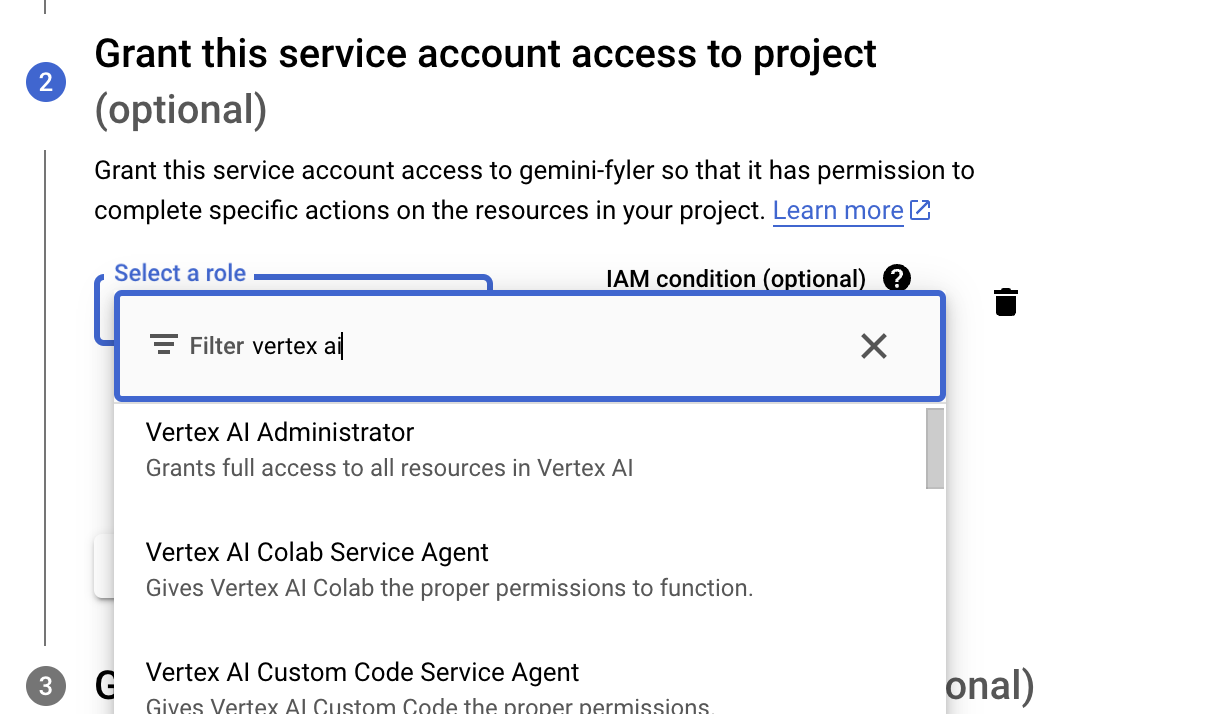



1.   Now, after you created service account access, got to keys and create a new key ( chose JSON format). This will automatically download the service account access JSON file for you.
2.  now the follow the code :)



In [ ]:

from google.oauth2 import service_account

# Replace 'path/to/your/service-account-key.json' with the path to your service account key file

import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'path/to/your/service-account-key.json'

from google.oauth2 import service_account

# Load credentials from the service account file
credentials = service_account.Credentials.from_service_account_file('path/to/your/service-account-key.json')

import google.auth
from google.cloud import aiplatform

# Set the project and credentials
project = 'project-id'
aiplatform.init(project=project, credentials=credentials)


In [ ]:
from langchain_google_vertexai import ChatVertexAI

# create Langchain LLM and Embeddings
flash = ChatVertexAI(
    model_name='gemini-1.5-flash'
)


In [ ]:
result = flash.invoke("write poem for me ")
print(result.content)



In [ ]:
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyPDFLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma


# load_qa_chain

Loads a chain that you can use to do QA over a set of documents, but it uses ALL of those documents.

chain_type="stuff" will not work because the number of tokens exceeds the limit. We can try other chain types like "map_reduce".

In [ ]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://dl.acm.org/doi/fullHtml/10.1145/3578265/",),)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | flash
    | StrOutputParser()
)

In [ ]:
retriever.get_relevant_documents("what are the names of the authors?")

[Document(page_content='REFERENCES', metadata={'language': 'en', 'source': 'https://dl.acm.org/doi/fullHtml/10.1145/3578265/', 'title': 'Attention Mechanism Architecture for Arabic Sentiment Analysis'}),
 Document(page_content='Authors’ addresses: M. Berrimi, A. Moussaoui, and M. Saidi, Department of Computer Science, University of Ferhat Abbas 1, Setif, Algeria; emails: Mohamed.Berrimi@univ-setif.dz, Abdelouahab.Moussaoui@univ-setif.dz, Mohamed.Saidi@univ-setif.dz; M. Oussalah, Faculty of ITEE, CMVS. University of Oulu, Oulu, Finland, email: Mourad.oussalah@oulu.fi.\nPermission to make digital or hard copies of part or all of this work for personal or classroom use is granted without fee provided that copies are not made or distributed for profit or commercial advantage and that copies bear this notice and the full citation on the first page. Copyrights for third-party components of this work must be honored. For all other uses, contact the owner/author(s).\n\n\n©2023 Copyright held b

In [ ]:
rag_chain.invoke("  what is the email of the first author? ")

'The email address of the first author, Mohamed Berrimi, is Mohamed.Berrimi@univ-setif.dz. This information is listed in the context provided under "Authors\' addresses." \n'

In [ ]:
rag_chain.invoke("اشرح لي بالعربي ملخص")

'تتناول هذه المقالة تحليل المشاعر في اللغة العربية باستخدام التعلم العميق. تُسلط المقالة الضوء على تحديات معالجة اللغة العربية، مثل اللهجات المتعددة ووفرة الأساليب البلاغية. ثم، تقدم المقالة نموذجًا جديدًا لتحليل المشاعر وتقييم أدائه على مجموعة من البيانات، وتُظهر تفوقه على النماذج الأساسية. \n'

In [ ]:
result['answer']